Generate training data using function for dx/dt

In [1]:
import torch
import torch.nn as nn
import numpy as np

# Define the ODE
def dxdt_func(x):
    dxdt = -x**3
    return dxdt

# Generate random training inputs
np.random.seed(0)
x_min, x_max = 0, 2
x = np.random.uniform(x_min, x_max, 500000)

# # Standardize the training inputs
# x_mean, x_std = np.mean(x), np.std(x)
# x_stand = (x - x_mean) / x_std

# Calculate the dydx training values
dxdt_train = dxdt_func(x)

# # Scale the training dydx values
# dxdt_mean, dxdt_std = np.mean(dxdt_train), np.std(dxdt_train)
# dxdt_scld = (dxdt_train - dxdt_mean) / dxdt_std

# dxdt_min, dxdt_max = np.min(dxdt_train), np.max(dxdt_train)
# dxdt_scld = (dxdt_train - dxdt_min) / (dxdt_max - dxdt_min) * 0.6 + 0.2

x = np.vstack((x))
input_train = torch.tensor(x, dtype=torch.float32)
dxdt_scld = torch.tensor(dxdt_train, dtype=torch.float32).view(-1, 1)

Define and train NN to approximate dx/dt with early stopping

In [2]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import copy

class ODENeuralNetwork(nn.Module):
    def __init__(self):
        super(ODENeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(1, 80) # 3 inputs (input layer) to hidden layer 1
        self.output_layer = nn.Linear(80, 1) # Hidden layer 3 to 1 output (output layer)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        # x = torch.relu(self.hidden1(x))
        # x = torch.relu(self.hidden2(x))
        x = (self.output_layer(x))
        return x
    
dxdt_model = ODENeuralNetwork()

batchsize = 500

# Create dataset and DataLoader for training in batches
dataset = TensorDataset(input_train, dxdt_scld)
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

loss_func = nn.MSELoss()
optimizer = optim.Adam(dxdt_model.parameters(), lr=0.01, weight_decay=0.01)
# Add weight decay
best_loss = float('inf')
patience = 10
patience_left = patience

# Train model
num_epochs = 150
for epoch in range(num_epochs):
    for x_batch, dxdt_batch in dataloader:
        # Evaluate model
        outputs = dxdt_model(x_batch)
        # Calculate loss
        loss = loss_func(outputs, dxdt_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Early stopping criteria
    if loss <= best_loss:
        best_loss = loss
        patience_left = patience
        best_model_weights = copy.deepcopy(dxdt_model.state_dict())
        best_epoch = epoch
    else:
        patience_left -= 1
        if patience_left == 0:
            break

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

# Use the best weights in the model
dxdt_model.load_state_dict(best_model_weights)

# Determine the best epoch and lost value when complete
print(f"Best epoch: {best_epoch}")
print(f"Smallest loss value: {best_loss:.8f}")

Epoch [10/150], Loss: 0.01910354
Best epoch: 7
Smallest loss value: 0.01308803


Plot to test the model for dx/dt

0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.006895482540130615
0.00689548254

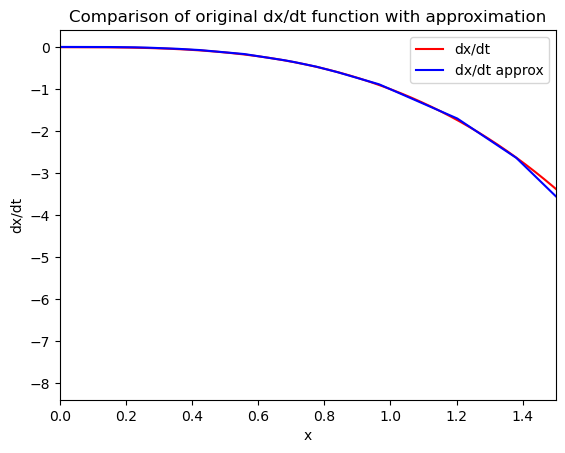

In [5]:
import matplotlib.pyplot as plt

x_plot = np.linspace(x_min, x_max, 10000)
# Make actual function
z1 = dxdt_func(x_plot)
shape_z1 = np.shape(z1)
zNN = np.zeros(shape=(shape_z1))

# Approximate with NN
def evaluations(x_test):
  
  x_test = torch.as_tensor([x_test], dtype=torch.float32)

  # Use NN model to determine the predicted output (dx/dt)
  dxdt_model.eval()
  with torch.no_grad():
    dxdt_pred = dxdt_model(x_test)
    print(dxdt_pred.item())
  return dxdt_pred

for i, x_test  in enumerate(x_plot):
    zNN[i] = evaluations(x_test)


plt.figure()
plt.plot(x_plot, z1, color='red', label='dx/dt')
plt.plot(x_plot, zNN, color='blue', label='dx/dt Approx.')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.legend(['dx/dt', 'dx/dt approx'])
plt.title('Comparison of original dx/dt function with approximation')
plt.xlim([0, 1.5])
plt.show()

Define the functions to use when solving for x0

In [6]:
import pyomo.environ as pyo

# Define dx/dt function
def dxdt_eval(x):
    # Convert to torch tensor to evaluate NN
    x_test = torch.as_tensor([x], dtype=torch.float32)

    dxdt_model.eval()
    with torch.no_grad():
        dxdt_nn = dxdt_model(x_test)

    return dxdt_nn.item()

# Define function to approximate value of x(t), solution of dx/dt
def x_approx(coeffs, t):
    '''
    Inputs:
    (coeffs): list of coefficients used in the polynomial approximation from t0 to tend (variable length)
    (t): time point to evaluate x(t) approximation
    '''
    x_approx = coeffs[0] + coeffs[1]*t + coeffs[2]*t**2 + coeffs[3]*t**3 + coeffs[4]*t**4
    return x_approx

# Use Pyomo to solve for new coefficients for x(t) approximation based on x0 guess
def get_coeffs(x0, coeff_guess, tklist):
    '''
    Inputs: x0, 
    Outputs: new coefficients for x(t) approximation (c0, c1, c2, c3, c4)

    Process:
    1. Define Pyomo variables for coefficients
    2. Define Pyomo constraints for equations to solve using collocation points
    3. Solve for coefficients
    '''
    # Create Pyomo model
    m = pyo.ConcreteModel()

    # Define the approximation coefficients as Pyomo variables
    m.c0 = pyo.Var()
    m.c1 = pyo.Var()
    m.c2 = pyo.Var()
    m.c3 = pyo.Var()
    m.c4 = pyo.Var()

    # Define the system of equations as Pyomo constraints
    def eq1(m):
        return m.c0 == x0
    def eq2(m):
        return dxdt_eval(x=x_approx(coeffs=coeff_guess, t=(tklist[0]))) == m.c1 + 2*m.c2*tklist[0] + 3*m.c3*tklist[0]**2 + 4*m.c4*tklist[0]**3
    def eq3(m):
        return dxdt_eval(x=x_approx(coeffs=coeff_guess, t=(tklist[1]))) == m.c1 + 2*m.c2*tklist[1] + 3*m.c3*tklist[1]**2 + 4*m.c4*tklist[1]**3
    def eq4(m):
        return dxdt_eval(x=x_approx(coeffs=coeff_guess, t=(tklist[2]))) == m.c1 + 2*m.c2*tklist[2] + 3*m.c3*tklist[2]**2 + 4*m.c4*tklist[2]**3
    def eq5(m):
        return dxdt_eval(x=x_approx(coeffs=coeff_guess, t=(tklist[3]))) == m.c1 + 2*m.c2*tklist[3] + 3*m.c3*tklist[3]**2 + 4*m.c4*tklist[3]**3
    
    m.eq1 = pyo.Constraint(rule=eq1)
    m.eq2 = pyo.Constraint(rule=eq2)
    m.eq3 = pyo.Constraint(rule=eq3)
    m.eq4 = pyo.Constraint(rule=eq4)
    m.eq5 = pyo.Constraint(rule=eq5)

    # Solve for Pyomo variables/coefficients
    # Dummy objective
    m.obj = pyo.Objective(expr=0, sense=pyo.minimize)
    solver = pyo.SolverFactory('ipopt')
    solver.solve(m)

    c0 = pyo.value(m.c0)
    c1 = pyo.value(m.c1)
    c2 = pyo.value(m.c2)
    c3 = pyo.value(m.c3)
    c4 = pyo.value(m.c4)

    # print(f"c0 = {c0}")
    # print(f"c1 = {c1}")
    # print(f"c2 = {c2}")
    # print(f"c3 = {c3}")
    # print(f"c4 = {c4}")

    c_list = [c0, c1, c2, c3, c4]

    return c_list



Solve for the collocation coefficients and minimize error between target x and x(tend)

In [7]:
# Define range of time values
t0, tend = 0, 1
# Target x value at tend
xd = 0.5

# Initialize list to store x0 values and pick initial guess
x0 = []
x0.append(1)

# Initialize array to store coefficients
coeff_guesses = []
# Make initial guess for the coefficients
coeff_guesses.append([x0[-1], 0, 0, 0, 0])

# Add proportionality constant for control, tolerance
K = 0.1
tol = 0.0001
err = []
err.append(10)

# Add max iterations and iteration counter
max_iters = 1000
iters = 0

print(f'Target x(tend) = x({tend}): {xd}')
print("Initial x0 guess: ", x0[0])
print(f'Prop. constant: {K}')


while abs(err[-1]) > tol:
    # Use x0 guess to solve for approximation coefficients
    c_guess = get_coeffs(x0[-1], coeff_guess=coeff_guesses[-1], tklist=[0.25, 0.5, 0.75, 1])
    # Append the new list to the list of coefficient guesses
    coeff_guesses.append(c_guess)
    
    # Solve for the x value at tend using the approximation
    x_tend = x_approx(coeff_guesses[-1], tend)

    # Error > 0 if x(tend) < xd, want to increase x0
    err.append(xd - x_tend)
    iters += 1

    if iters >= max_iters:
        print(f'Max iterations reached! Error: {err[-1]}')
        print(f'Final x0: {x0[-1]}')
        print(err)
        print(x0)
        break
    if abs(err[-1]) < tol:
        print(f'\nSolution obtained! x0 = {x0[-1]}')
        print(f'x(tend) = {x_tend}')
        print(x[-1])
        print(f'Final error value: {err[-1]}')
        print(f'Final coefficients: {coeff_guesses[-1]}')
        print(f'Iterations used: {iters}')
        print(f'\nCoefficient list: {coeff_guesses}')
        break
    # Use prop. constant and last error for next x0 value
    x0.append(x0[-1] + K*err[-1])


Target x(tend) = x(1): 0.5
Initial x0 guess:  1
Prop. constant: 0.1



Solution obtained! x0 = 0.6976318597562768
x(tend) = 0.5000965883103667
[0.53123405]
Final error value: -9.658831036674087e-05
Final coefficients: [0.6976318597562768, -0.34154532849788666, 0.23807874321937567, -0.12103692690531424, 0.026968240737915095]
Iterations used: 202

Coefficient list: [[1, 0, 0, 0, 0], [1.0, -1.001954436302185, 0.0, 0.0, 0.0], [1.0501954436302186, -0.985543729737402, 1.456349081359807, -0.9350860007107301, 0.2212497629225272], [1.0194789878837764, -1.0290809273719788, 0.9382894436518354, -0.7639395395914719, 0.22948710123697946], [1.0300554813028624, -0.9282395057380204, 0.9704181763033083, -0.5119498372077952, 0.11747259895006844], [1.01227978994182, -1.0013892650604248, 0.9892021020253493, -0.6661731402079252, 0.17826731999715104], [1.011061109272223, -0.9256373345851897, 0.9791362384955083, -0.6111765702565505, 0.16798845926920547], [0.9989239190527034, -0.9251825809478759, 0.8872904181480402, -0.5574696063995354, 0.14606404304504356], [0.9939612997628658,

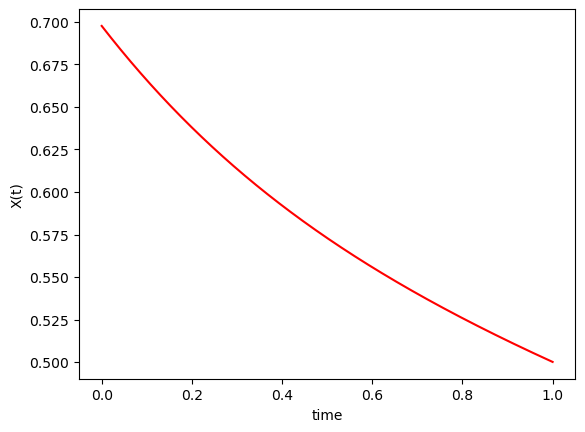

In [11]:
# Use final coefficients in approximate equation for x(t)

t_plot = np.linspace(t0,tend,1000)
x_plot = x_approx(coeff_guesses[-1], t_plot)

plt.figure()
plt.plot(t_plot, x_plot, color='red')
plt.xlabel('time')
plt.ylabel('X(t)')
plt.show()